# Experimental design (enhancing/relaxation of climatological wind field)

a) climatological wind field in JRA
b) historical trends in JRA and CMIP
c) projected trends in CMIP
d) applied perturbation

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import cosima_cookbook as cc
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from xarrayMannKendall import *

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:35269 Dashboard: /proxy/35043/status,Cluster Workers: 6 Cores: 24 Memory: 250.00 GiB


Load datasets

In [44]:
session = cc.database.create_session()
ht = cc.querying.getvar('01deg_jra55v13_ryf9091', 'ht', session, n = 1).sel(yt_ocean = slice(None, -50))
ht = ht.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
ht['_lon_adj'] = xr.where(ht['lon'] < 0, ht['lon'] + 360, ht['lon'])
ht = ht.swap_dims({'lon': '_lon_adj'})
ht = ht.sel(**{'_lon_adj': sorted(ht._lon_adj)}).drop('lon')
ht = ht.rename({'_lon_adj': 'lon'})

In [87]:
shelf_regions = xr.open_dataset('~/g_e14/misc/Antarctic_shelf_basins.nc')
basins = shelf_regions['basins'].where(shelf_regions['basins'] != 100, np.nan)

basins = basins.rename(({'xt_ocean':'x', 'yt_ocean':'y'}))
basins['_lon_adj'] = xr.where(basins['x'] < 0, basins['x'] + 360, basins['x'])
basins = basins.swap_dims({'x': '_lon_adj'})
basins = basins.sel(**{'_lon_adj': sorted(basins._lon_adj)}).drop('x')
basins = basins.rename({'_lon_adj': 'x'})

locs = list(shelf_regions['basin_lookup']['region'][:-1].values)
locs.remove('East Antarctica 04')

In [2]:
# JRA55do-v14
uas = {}
vas = {}
uas['JRA'] = xr.open_dataset('/scratch/e14/jn8053/jra55/uas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))
vas['JRA'] = xr.open_dataset('/scratch/e14/jn8053/jra55/vas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))

# CMIP6 multimodel mean
uas['CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/uas-hist-monthly-1958_2015.nc')
vas['CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/vas-hist-monthly-1958_2015.nc')

In [75]:
# CMIP6 individual models
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/historical/uas/uas*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/historical/vas/vas*')
uas_cmip = {}
vas_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i])
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i])
model_names = list(uas_cmip.keys())

Calculate trends for historical period

In [6]:
MK_trends_uas = {}
MK_trends_vas = {}
for n in ['JRA', 'CMIP6']:
    u = uas[n]['uas']
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_uas[n] = MK_class.compute()
    
    v = vas[n]['vas']
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_vas[n] = MK_class.compute()

In [76]:
MK_trends_uas_cmip = {}
MK_trends_vas_cmip = {}
for n in model_names:
    u = uas_cmip[n]['uas']
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_uas_cmip[n] = MK_class.compute()
    
    v = vas_cmip[n]['vas']
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_vas_cmip[n] = MK_class.compute()

In [94]:
uas_trends = np.empty([len(model_names), len(locs)])
vas_trends = np.empty([len(model_names), len(locs)])
for i in range(len(model_names)):
    u = MK_trends_uas_cmip[model_names[i]]['trend'].interp(x = basins['x'], y = basins['y'])
    v = MK_trends_vas_cmip[model_names[i]]['trend'].interp(x = basins['x'], y = basins['y'])
    for j in range(len(locs)):
        uas_trends[i, j] = u.where(basins == j+2, np.nan).mean(['x', 'y'])
        vas_trends[i, j] = v.where(basins == j+2, np.nan).mean(['x', 'y'])

In [101]:
uas_trends_jra = np.empty(10)
vas_trends_jra = np.empty(10)
for j in range(len(locs)):
        uas_trends_jra[j] = MK_trends_uas['JRA']['trend'].interp(x = basins['x'], y = basins['y']).where(basins == j+2, np.nan).mean(['x', 'y'])
        vas_trends_jra[j] = MK_trends_vas['JRA']['trend'].interp(x = basins['x'], y = basins['y']).where(basins == j+2, np.nan).mean(['x', 'y'])

Plot

In [126]:
def figure_1():
    fig = plt.figure(figsize = (20, 8))
    gr = gs.GridSpec(3, 3, figure = fig, width_ratios = [1, 1, .03])
    axs = [fig.add_subplot(gr[0,0], projection = ccrs.Mercator(central_longitude = 200)),
           fig.add_subplot(gr[0,1], projection = ccrs.Mercator(central_longitude = 200)),
           fig.add_subplot(gr[1,0], projection = ccrs.Mercator(central_longitude = 200)),
           fig.add_subplot(gr[1,1], projection = ccrs.Mercator(central_longitude = 200)),
           fig.add_subplot(gr[0,2]),
           fig.add_subplot(gr[1,2]),
           fig.add_subplot(gr[2,0]),
           fig.add_subplot(gr[2,1])]
    for ax, label in zip(axs[:4], ['a)', 'b)', 'c)', 'd)']):
        ax.text(-0.08, .9, label, transform=ax.transAxes, size = 12, weight='bold')
        ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                           edgecolor = 'black', facecolor = 'white'))
        ax.set_xticks(np.arange(-150, 200, 50), crs = ccrs.PlateCarree())
        ax.set_yticks([-75, -70, -65, -60, -55], crs = ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label = False)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.contour(ht['lon'], ht['lat'], ht, levels = [1000, 3000], colors = 'k', linewidths = 0.5, zorder = 2, transform = ccrs.PlateCarree())
    axs[-2].text(-0.08, .9, 'e)', transform=axs[-2].transAxes, size = 12, weight='bold')
    axs[-1].text(-0.08, .9, 'f)', transform=axs[-1].transAxes, size = 12, weight='bold')
    plt.tight_layout()
    
    return fig, axs

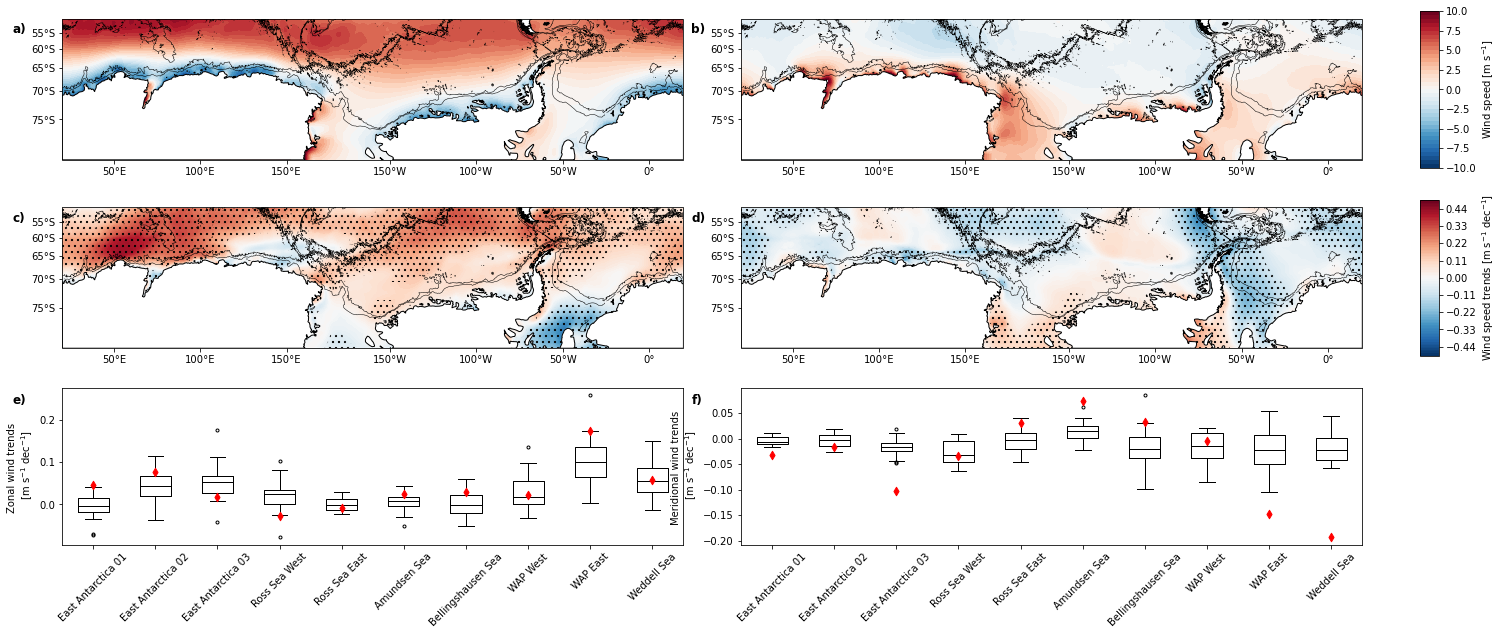

In [127]:
fig, axs = figure_1();
# Mean JRA
u = axs[0].contourf(uas['JRA']['lon'], uas['JRA']['lat'], uas['JRA']['uas'].mean('time'), 
                    levels = np.arange(-10, 10.5, .5), cmap = 'RdBu_r', transform = ccrs.PlateCarree())
v = axs[1].contourf(vas['JRA']['lon'], vas['JRA']['lat'], vas['JRA']['vas'].mean('time'), 
                    levels = np.arange(-10, 10.5, .5), cmap = 'RdBu_r', transform = ccrs.PlateCarree())
fig.colorbar(u, cax = axs[4]).set_label('Wind speed [m s$^{-1}$]')
# JRA trends historical period
u = axs[2].contourf(MK_trends_uas['JRA']['x'], MK_trends_uas['JRA']['y'], 120*MK_trends_uas['JRA']['trend'], 
                    levels = np.arange(-.5, .51, .01), cmap = 'RdBu_r', transform = ccrs.PlateCarree())
v = axs[3].contourf(MK_trends_vas['JRA']['x'], MK_trends_vas['JRA']['y'], 120*MK_trends_vas['JRA']['trend'], 
                    levels = np.arange(-.5, .51, .01), cmap = 'RdBu_r', transform = ccrs.PlateCarree())
fig.colorbar(u, cax = axs[5]).set_label('Wind speed trends [m s$^{-1}$ dec$^{-1}$]')
# Hatch significance
u = axs[2].contourf(MK_trends_uas['JRA']['x'], MK_trends_uas['JRA']['y'], MK_trends_uas['JRA']['p'].where(MK_trends_uas['JRA']['p'] <= .05), 
                    colors = ['none'], hatches = ['..'], transform = ccrs.PlateCarree())
v = axs[3].contourf(MK_trends_vas['JRA']['x'], MK_trends_vas['JRA']['y'], MK_trends_vas['JRA']['p'].where(MK_trends_vas['JRA']['p'] <= .05), 
                    colors = ['none'], hatches = ['..'], transform = ccrs.PlateCarree())
# Boxplot of trends per region
axs[6].boxplot(uas_trends*120, sym = '.', medianprops=dict(color = 'k'), labels = locs, zorder = 0);
axs[6].scatter(np.arange(1,11,1), uas_trends_jra*120, color = 'r', marker = 'd', zorder = 1)
axs[6].set_xticklabels(labels = locs, rotation = 45);
axs[6].set_ylabel('Zonal wind trends \n [m s$^{-1}$ dec$^{-1}$]')
axs[7].boxplot(vas_trends*120, sym = '.', medianprops=dict(color = 'k'), labels = locs, zorder = 0);
axs[7].scatter(np.arange(1,11,1), vas_trends_jra*120, color = 'r', marker = 'd', zorder = 1)
axs[7].set_ylabel('Meridional wind trends \n [m s$^{-1}$ dec$^{-1}$]')
axs[7].set_xticklabels(labels = locs, rotation = 45);
plt.savefig(figdir+'figure-1-v0.png', facecolor = 'white', bbox_inches = 'tight')